Я не знаю работает ли мой код полностью. Вычислительных возможностей моего ноутбука не хватает для проверки. Colab после загрузки не видит датасет. Я считаю, что именно о таких вещах (как работать с большими данными) и нужно говорить во время обучения.

In [5]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

In [6]:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [7]:
data_dir = r'C:\Users\vmakh\OneDrive\Desktop\Python-20220419T075236Z-001\Python\PyTorch\Курсовая\Data\archive\leapGestRecog'
print(os.listdir(data_dir))

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', 'test', 'train']


Создадим директории train and test

In [52]:
import os
import random
import shutil

# Укажем главную директорию
main_dir = data_dir

# создадим директории train, test
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"

# разбивка
split_ratio = 0.5

# идем по каждой папке
for person_folder in os.listdir(main_dir):
    person_folder_path = os.path.join(main_dir, person_folder)
    if not os.path.isdir(person_folder_path):
        continue

    # идем по жестам каждой персоны
    for gesture_folder in os.listdir(person_folder_path):
        gesture_folder_path = os.path.join(person_folder_path, gesture_folder)
        if not os.path.isdir(gesture_folder_path):
            continue

        # создадим папку жестов
        image_files = os.listdir(gesture_folder_path)

        # перемешаем
        random.shuffle(image_files)

        # разделим на train, test
        split_index = int(len(image_files) * split_ratio)
        train_files = image_files[:split_index]
        test_files = image_files[split_index:]

        # создадим директории train, test если их нет
        person_train_dir = os.path.join(train_dir, person_folder, gesture_folder)
        person_test_dir = os.path.join(test_dir, person_folder, gesture_folder)
        os.makedirs(person_train_dir, exist_ok=True)
        os.makedirs(person_test_dir, exist_ok=True)

        # скопируем тренировочные файлы в train 
        for train_file in train_files:
            src_file_path = os.path.join(gesture_folder_path, train_file)
            dst_file_path = os.path.join(person_train_dir, train_file)
            shutil.copy(src_file_path, dst_file_path)

        # скопируем тестировочные файлы в test
        for test_file in test_files:
            src_file_path = os.path.join(gesture_folder_path, test_file)
            dst_file_path = os.path.join(person_test_dir, test_file)
            shutil.copy(src_file_path, dst_file_path)


In [8]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']
test Classes - ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


In [9]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
test_ds = ImageFolder(data_dir + '/test', test_tfms)

In [10]:
train_ds

Dataset ImageFolder
    Number of datapoints: 10105
    Root location: C:\Users\vmakh\OneDrive\Desktop\Python-20220419T075236Z-001\Python\PyTorch\Курсовая\Data\archive\leapGestRecog/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

Определим размер батча:

In [11]:
batch_size = 50

И создадим наши даталоадеры:

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)

Создадим функцию для просмотра случайных картинок из получившегося датасета:

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 240, 640])


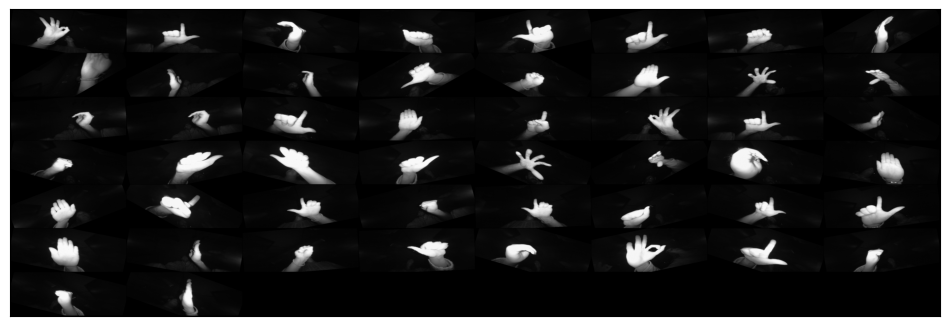

In [14]:
show_batch(train_dl)

Напишем функции для перевода наших Даталоадеров на необходимое оборудование:

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

Узнаем какое оборудование у нас:

In [16]:
device = get_default_device()
device

device(type='cpu')

Воспользуемся функциями написанными выше:

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

Шаг 2. Опишем модель

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [19]:
model = to_device(ResNet(1, len(classes_train)), device)

In [20]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

Шаг 3. Обучение

In [21]:
torch.cuda.empty_cache()
history = []

epochs = 12
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [22]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

12 epochs, 203 total_steps per epoch


In [23]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data, labels = Variable(data), Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)


RuntimeError: [enforce fail at C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 3932160000 bytes.

In [24]:
torch.save(model.state_dict(), './hand_gesture.pth')

In [25]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('./hand_gesture.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_dl):
        images, labels = data
        images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        outputs = net(images)
        plt.title(f'gaused - {outputs[0].argmax()}, groud truth - {labels[0]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>5:
            break

In [29]:
import cv2
import tensorflow as tf
import numpy as np
import pickle

# загрузка модели из файла
with open('./hand_gesture.pth', 'rb') as f:
    model = pickle.load(f)

# инициализация камеры
cap = cv2.VideoCapture(0)

# загрузка классов жестов
classes = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


# создание функции для обработки изображения и применения модели
def process_image(img):
    # определение лица на кадре
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # если лицо обнаружено, происходит обработка жестов на кадре
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        roi = gray[y:y+h, x:x+w]
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        
        # изменение размера изображения и нормализация
        img = cv2.resize(roi, (128, 128))
        img = img / 255.0
        
        # применение модели и получение результата
        result = model.predict(np.array([img]))
        prediction = np.argmax(result)
        gesture = classes[prediction]
        cv2.putText(img, gesture, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    
    return img

while True:
    # считывание кадра с камеры
    ret, frame = cap.read()
    
    # обработка кадра
    processed_frame = process_image(frame)
    
    # отображение кадра
    cv2.imshow('frame', processed_frame)
    
    # выход при нажатии клавиши 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# освобождение ресурсов
cap.release()
cv2.destroyAllWindows()


UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.